<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/LSTM_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The objective of this tutorial

Our goal in this tutorial is to provide simple examples of the LSTM model so that you can better understand its functionality and how it can be used in a domain.

After completing this tutorial, you will know:


```
- What is an LSTM (Long Short-Term Memory)
- How LSTMs work and their structure compared to traditional RNNs
- The purpose and benefits of using LSTMs for tasks such as sequence generation
- How to implement an LSTM in code using PyTorch
- How to train and fine-tune an LSTM for a specific task
- Common challenges and pitfalls to avoid when working with LSTMs
- The difference between various types of RNNs (RNN and LSTM)
```




#Long Short-Term Memory (LSTM) with PyTorch

LSTMs are a type of RNN, so you will gain a better understanding of LSTMs by understanding RNN concepts.


## A quick recap on RNNs

By processing inputs sequentially, RNNs calculate outputs by considering the context of previous inputs. As a result, the neural network can carry information over different time steps rather than keeping each input as an independent variable.

Due to the problem of vanishing/exploding gradients, RNNs are unable to work with longer sequences and hold on to long-term dependencies.


<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/RNN_Vanishing_Exploding.png" width="700">

#### Exploding gradient problem
```
- The gradients will be exploded if the gradient formula is deep (large T−t) and a single or multiple gradient values becoming 
very high (if Wh2h > 1).

- This is less concerning than vanishing gradient problem because it can be easily solved by clipping the gradients 
at a predefined threshold value.
```

#### Vanishing gradient problem
```
- The gradients will be vanished if the gradient formula is deep (large T−t) and a single or multiple gradient values 
becoming very low (if -1 < Wh2h < 1).
- Calculating the error after several time step with respect to the first one, there will be a long dependency.
- If any one of the gradients approached 0, all the gradient would rush to zero exponentially fast 
due to the multiplication of chain rule.
- This state would no longer help the network to learn anything which is known as vanishing gradient problem.
```
> Below is the effects of applying a sigmoid function over and over again, it became very flattened with no detectable slope where its gradient become close to 0.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/RNN_Vanishing.png" width="300">



Due to these issues, RNNs are unable to work with longer sequences and hold on to long-term dependencies, making them suffer from “short-term memory”.

This problem can be solved in 3 ways:.
```
- Activation Function (ReLU instead of Tanh)
- Weights initialization
- Changing Network Architecture
```

This section will focus on the 3rd solution that is changing the network architecture. In this solution, you modify the architecture of RNNs and use the more complex recurrent unit with Gates such as LSTMs or GRUs (Gated Recurrent Units).

## LSTM: How does it help?

LSTMs are a special type of Neural Networks that perform similarly to Recurrent Neural Networks, but run better than RNNs, and further solve some of the important shortcomings of RNNs for long term dependencies, and vanishing gradients.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/RNN-LSTM.png" width="700">



### Long-term Memory

The key building blocks behind LSTM are a cell state known as Long-term Memory and three different types of gates. Information is added or removed through these gates. Let's check these structuers:

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_Gates.png" width="700"> 

> Cell state is a memory of the LSTM cell and hidden state (cell output) is an output of this cell. Cells do have internal cell state, often abbreviated as “c”, and cells output is what is called a “hidden state”, abbreviated as “h”. Regular RNNs have just the hidden state and no cell state.


These gates are called the Input Gate, the Forget Gate, and the Output Gate. There are many variants to the names of these gates; nevertheless, the calculations and workings of these gates are mostly the same.

> Forget Gate: The forget gate decides which information from the long-term memory should be kept or discarded.

> Input Gate: The input gate decides what new information will be stored in the long-term memory. It only works with the information from the current input and the short-term memory from the previous time step. Therefore, it has to filter out the information from these variables that are not useful.

> Output Gate: The output gate will take the current input, the previous short-term memory, and the newly computed long-term memory to produce the new short-term memory/hidden state which will be passed on to the cell in the next time step. The output of the current time step can also be drawn from this hidden state.

### How does a Gate work in LSTM? 

A gate consists of a neural net layer, like a sigmoid, and a pointwise multiplication shown in red in the figure above. 

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/Sigmoid_pointwise-multiplication.jpeg" width="200"> 
> Sigmoid is forcing the input between 0 and 1, which determines how much information is captured when passed through the gate, and how much is retained when it passes through the gate. For example, 0 means no information is retained, and 1 means all information is retained.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_cellstate.png" width="500"> 

###Structure of LSTM

Now, let’s dig deeper to understand what is happening under the hood. LSTM consists of five different parts:
1. Parameters (This includes the weights and biases of the input-to-hidden layer, the hidden-to-hidden layer, and the hidden-to-output layer.)
> *The hidden state is used to capture the information from the previous time steps, but this information is not relevant after the training process is finished. Therefore, resetting the hidden-to-hidden layer parameters to zero ensures that the network starts with a clean slate for making predictions on new, unseen data.*

2. The hidden state (also known as the Short-term Memory)
> *you can think of the hidden state as representing the "memory" of the network, which is updated at each time step and used to produce the output.*

3. The cell state (also known as the Long-term Memory)
> 

4. Non-Linear part (Activation Function (Tanh))
> As you can see in the equation above, you feed in both input vector Xt and the previous state ht-1 into the function. Here you’ll have 2 separate weight matrices then apply the Non-linearity (tanh) to the sum of input Xt and previous state ht-1 after multiplication to these 2 weight matrices. 

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_formula.png" width="800">


5. Linear part: Finally, you’ll have the output vector ŷt at the timestamp t.
> <img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/sequence-3.png" width="150"> 


## LSTM code implementation

Let's get started with Data Preparation for the LSTM  implementation!

In [2]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Data Preparation

To understand how should we prepare the data for LSTM, we’ll use a simple dataset as a Timeseries Forecasting example. Below is the full sequence of values and their restructuring as a training and testing dataset.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/SequenceDataPerparation.webp" width="400"> 

Now, let’s separate the datasets into batches!

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/Seq_DataPerparation_2.webp" width="100"> 

In [87]:
stock_data = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [124]:
# Split the data into sequences for LSTM input
n_steps = 3
sequence_data = []
sequence_labels = []

for i in range(len(stock_data) - n_steps):
    sequence_data.append(stock_data[i:i+n_steps])
    sequence_labels.append(stock_data[i+n_steps])

sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:4]
train_labels = sequence_labels[:4]
test_data = sequence_data[4:]
test_labels = sequence_labels[4:]

In [125]:
print("Train data: \n", train_data)
print("Labels: \n", train_labels)

Train data: 
 [[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]]
Labels: 
 [40 50 60 70]


Implementing code for LSTM and RNN requires sequential data preparation. The data preparation process for these models is visualized here!


<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/sequence.gif" width="600"> 


In [126]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

We then have to prepare the dataset. We need the data as Pytorch tensors so that we can use that in our model which we will make. We use the dataloader so that we can extract the data in batches. This is especially helpful for large datasets.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/TensorDataset.webp" width="600"> 



### Training LSTM

In order to create a LSTM, we follow the same steps as for implementing an ANN!


```
- Creating a Neural Network
- Network Evaluation
- Gradient Calculation
- Back Propagation
- Training
```




<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_dynamic.gif" width="600"> 

In [153]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 3
hidden_size = 6
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


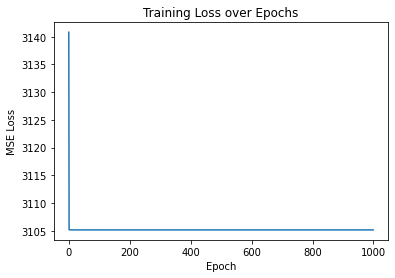

Test MSE: 7180.60693359375


In [154]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        # Initialize the hidden state and the cell state
        # The hidden state and the cell state reset to zero for every epoch
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the LSTM model
mse = 0

with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

# Save the trained LSTM model
# ...

### LSTM and RNN comparison
Let's implement RNN network for this dataset and compare the structure of the codes for these two models (RNN and LSTM)!

In [155]:
# Initialize the RNN model
input_size = 3
hidden_size = 6
output_size = 1
num_epochs= 10

rnn = nn.RNN(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.01)

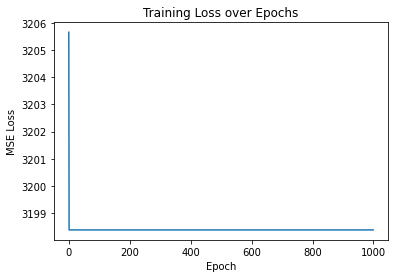

Test MSE: 7324.67333984375


In [156]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        

        # Initialize the hidden state 
        hidden = torch.zeros(data.size(0), hidden_size)

        # Run the forward pass
        output, hidden = rnn(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the LSTM model
mse = 0

with torch.no_grad():
    for data, label in test_loader:
        hidden = torch.zeros(data.size(0), hidden_size)
        output, hidden = rnn(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

# Save the trained RNN model
# ...

### Hands-On Learning Project: S&P 500 stock data

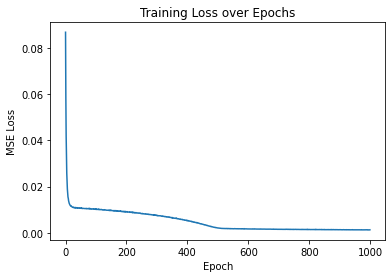

Test MSE: 0.06661457534292396


In [2]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the stock data
stock_data = pd.read_csv('https://raw.githubusercontent.com/rashida048/Datasets/master/stock_data.csv')
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']])
data_s = pd.DataFrame(data_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
stock_data = data_s[['Open']].to_numpy()

# Split the data into sequences for RNN input
sequence_length = 30
sequence_data = []
sequence_labels = []
for i in range(len(stock_data) - sequence_length):
    sequence_data.append(stock_data[i:i+sequence_length])
    sequence_labels.append(stock_data[i+sequence_length])
sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:2000]
train_labels = sequence_labels[:2000]
test_data = sequence_data[2000:]
test_labels = sequence_labels[2000:]

# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialize the RNN model
input_size = 1
hidden_size = 6
output_size = 1
num_epochs= 10

rnn = nn.RNN(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.01)

# Train the RNN model
num_epochs = 1000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0

    for i, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        hidden = torch.zeros(1, data.size(0), hidden_size)
        output, hidden = rnn(data.float(), hidden)
        output = fc(hidden[-1])

        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the RNN model
mse = 0

with torch.no_grad():
    for data, label in test_loader:
        hidden = torch.zeros(1, data.size(0), hidden_size)
        output, hidden = rnn(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

# Save the trained RNN model
# ...

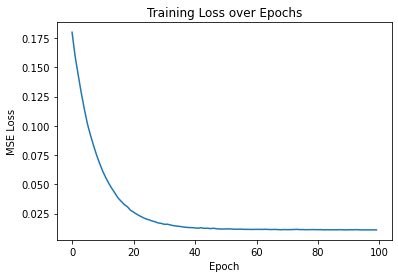

Test MSE: 0.1531948384389388


In [3]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the stock data
stock_data = pd.read_csv('https://raw.githubusercontent.com/rashida048/Datasets/master/stock_data.csv')
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']])
data_s = pd.DataFrame(data_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
stock_data = data_s[['Open']].to_numpy()

# Split the data into sequences for lstm input
sequence_length = 30
sequence_data = []
sequence_labels = []
for i in range(len(stock_data) - sequence_length):
    sequence_data.append(stock_data[i:i+sequence_length])
    sequence_labels.append(stock_data[i+sequence_length])
sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:2000]
train_labels = sequence_labels[:2000]
test_data = sequence_data[2000:]
test_labels = sequence_labels[2000:]

# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialize the LSTM model
input_size = sequence_data.shape[2]
hidden_size = 6
output_size = 1

lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

# Train the lstm model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0

    for i, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        hidden = (torch.zeros(1, data.size(0), hidden_size),
                  torch.zeros(1, data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[0][-1])

        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the lstm model
mse = 0

with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(1, data.size(0), hidden_size),
                  torch.zeros(1, data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[0][-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

# Save the trained lstm model
# ...